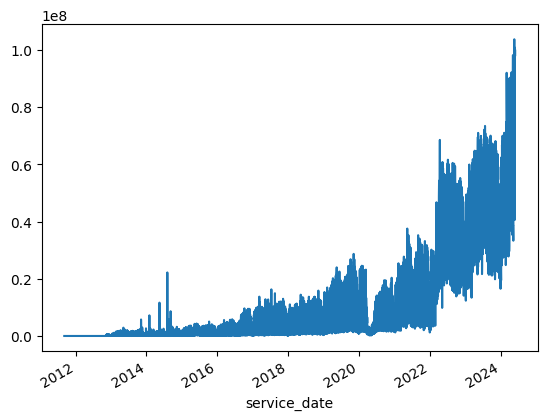

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error

df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")


df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))


train = df.groupby(["service_date"])["sum_price"].sum()
train


train_after_covid = train[train.index > "2022-02-24"]
train_after_covid = train
train_after_covid.plot()


train_after_covid = train_after_covid.reset_index()


train_after_covid.columns = ["date", "forecast_value"]


submission = pd.read_csv("sample_submission.csv")
train_after_covid = pd.concat([train_after_covid, submission], axis=0)


train_after_covid = train_after_covid.reset_index(drop=True)
train_after_covid["date"] = pd.to_datetime(train_after_covid["date"])

train_after_covid = train_after_covid.sort_values(by="date")

In [ ]:
def create_date_features(df):
    df = df.copy()
    df["month"] = df.date.dt.month.astype("int8")
    df["day_of_month"] = df.date.dt.day.astype("int8")
    df["day_of_year"] = df.date.dt.dayofyear.astype("int16")
    df["week_of_month"] = (df.date.apply(lambda d: (d.day - 1) // 7 + 1)).astype("int8")
    df["week_of_year"] = (df.date.dt.isocalendar().week).astype("int8")
    df["day_of_week"] = (df.date.dt.dayofweek + 1).astype("int8")
    df["year"] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    # df["quarter"] = df.date.dt.quarter.astype("int8")
    # df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    # df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    # df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    # df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    # df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    # df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    # df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    # df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df


train_after_covid_with_features = create_date_features(train_after_covid)

In [ ]:
def create_rolling_features(df, column, lags, windows, ew_windows):
    df = df.copy()
    for lag in lags:
        lagged_col = df[column].shift(lag)

        # df[f'lag_{lag}'] = lagged_col

        for window in windows:

            df[f"rolling_mean_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).mean()
            df[f"rolling_median_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).median()

            # Min and Max
            df[f"rolling_min_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).min()
            df[f"rolling_max_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).max()

            # Standard Deviation
            df[f"rolling_std_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).std()

            # Skewness
            df[f"rolling_skew_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).skew()

            # Percentiles
            df[f"rolling_10th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.1)
            df[f"rolling_90th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.9)

        for ew_window in ew_windows:
            df[f"ewm_mean_lag{lag}_win{ew_window}"] = lagged_col.ewm(
                span=ew_window
            ).mean()
            df[f"ewm_std_lag{lag}_win{ew_window}"] = lagged_col.ewm(span=ew_window).std()
            df[f"ewm_var_lag{lag}_win{ew_window}"] = lagged_col.ewm(span=ew_window).var()
            df[f"ewm_corr_lag{lag}_win{ew_window}"] = lagged_col.ewm(
                span=ew_window
            ).corr()
    return df


lags = [31, 38, 45, 365, 366]
windows = [7, 14, 21, 28, 35, 42, 56]
ew_windows = [7, 14, 21, 28, 35, 42, 56]

# lags = [31, 38, 45]
# windows = [7, 14, 21, 28, 35, 42]
# lags = [31, 38]
# windows = [7, 14, 21, 28, 35, 42]

In [ ]:
catboost_train = create_rolling_features(
    train_after_covid_with_features, "forecast_value", lags, windows, ew_windows
)[max(lags) + max(windows) - 1 :]
catboost_train

/tmp/ipykernel_179633/3572121117.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rolling_max_lag{lag}_win{window}'] = lagged_col.rolling(window=window).max()
/tmp/ipykernel_179633/3572121117.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rolling_std_lag{lag}_win{window}'] = lagged_col.rolling(window=window).std()
/tmp/ipykernel_179633/3572121117.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

,date,forecast_value,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,...,ewm_var_lag366_win35,ewm_corr_lag366_win35,ewm_mean_lag366_win42,ewm_std_lag366_win42,ewm_var_lag366_win42,ewm_corr_lag366_win42,ewm_mean_lag366_win56,ewm_std_lag366_win56,ewm_var_lag366_win56,ewm_corr_lag366_win56
421,2014-01-21,1.440472e+06,1,21,21,3,4,2,2014,0,...,3.551646e+10,1.0,2.212941e+05,1.921287e+05,3.691343e+10,1.0,2.195403e+05,1.966855e+05,3.868519e+10,1.0
422,2014-01-22,1.148345e+06,1,22,22,4,4,3,2014,0,...,3.510914e+10,1.0,2.127146e+05,1.910806e+05,3.651180e+10,1.0,2.126598e+05,1.956218e+05,3.826789e+10,1.0
423,2014-01-23,1.813668e+06,1,23,23,4,4,4,2014,0,...,3.333527e+10,1.0,2.092588e+05,1.868906e+05,3.492810e+10,1.0,2.098677e+05,1.921310e+05,3.691432e+10,1.0
424,2014-01-24,1.813134e+06,1,24,24,4,4,5,2014,1,...,3.199661e+10,1.0,2.040754e+05,1.836418e+05,3.372432e+10,1.0,2.056599e+05,1.893882e+05,3.586788e+10,1.0
425,2014-01-25,3.968600e+04,1,25,25,4,4,6,2014,1,...,3.169137e+10,1.0,1.957276e+05,1.828515e+05,3.343467e+10,1.0,1.988721e+05,1.886106e+05,3.557394e+10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,2024-06-26,0.000000e+00,6,26,178,4,26,3,2024,0,...,3.289365e+14,1.0,5.069019e+07,1.805547e+07,3.260000e+14,1.0,5.039007e+07,1.797921e+07,3.232519e+14,1.0
4229,2024-06-27,0.000000e+00,6,27,179,4,26,4,2024,0,...,3.137278e+14,1.0,5.104174e+07,1.770403e+07,3.134326e+14,1.0,5.066581e+07,1.772113e+07,3.140386e+14,1.0
4230,2024-06-28,0.000000e+00,6,28,180,4,26,5,2024,1,...,2.983235e+14,1.0,5.133079e+07,1.733808e+07,3.006088e+14,1.0,5.089705e+07,1.745041e+07,3.045170e+14,1.0
4231,2024-06-29,0.000000e+00,6,29,181,5,26,6,2024,1,...,2.871034e+14,1.0,5.180048e+07,1.706634e+07,2.912598e+14,1.0,5.126660e+07,1.725271e+07,2.976560e+14,1.0


In [ ]:
catboost_train = catboost_train.drop("date", axis=1)

In [ ]:
X_train = catboost_train[: -len(submission)].drop("forecast_value", axis=1)
y_train = catboost_train[: -len(submission)]["forecast_value"]
X_test = catboost_train[-len(submission) :].drop("forecast_value", axis=1)

In [ ]:
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(iterations=3000), lags=365)

forecaster.fit(y=y_train, exog=X_train)

Learning rate set to 0.020351
0:	learn: 20052626.5463138	total: 289ms	remaining: 14m 27s
1:	learn: 19735232.2027758	total: 332ms	remaining: 8m 17s
2:	learn: 19391357.3268354	total: 374ms	remaining: 6m 13s
3:	learn: 19068557.8688405	total: 416ms	remaining: 5m 11s
4:	learn: 18743520.8563880	total: 456ms	remaining: 4m 32s
5:	learn: 18428287.3188331	total: 495ms	remaining: 4m 6s
6:	learn: 18128559.8064777	total: 533ms	remaining: 3m 47s
7:	learn: 17824874.2488691	total: 572ms	remaining: 3m 33s
8:	learn: 17523889.0536733	total: 612ms	remaining: 3m 23s
9:	learn: 17235358.2234713	total: 653ms	remaining: 3m 15s
10:	learn: 16956326.5951213	total: 693ms	remaining: 3m 8s
11:	learn: 16681870.0588291	total: 733ms	remaining: 3m 2s
12:	learn: 16422998.9308947	total: 772ms	remaining: 2m 57s
13:	learn: 16159635.9547098	total: 811ms	remaining: 2m 52s
14:	learn: 15918267.4778933	total: 850ms	remaining: 2m 49s
15:	learn: 15662696.5943255	total: 889ms	remaining: 2m 45s
16:	learn: 15411365.1895678	total: 928

In [ ]:
steps = 30
predictions = forecaster.predict(steps=steps, exog=X_test)

<Axes: >

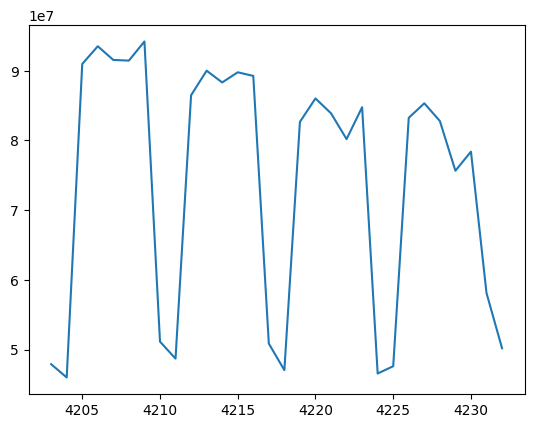

In [ ]:
predictions.plot()

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission["forecast_value"] = predictions.to_numpy()
submission.to_csv("skforecast.csv", index=False)